In [18]:
import json
import itertools
import os
import pandas as pd
from matplotlib import pyplot as plt
from IPython.core.display import HTML

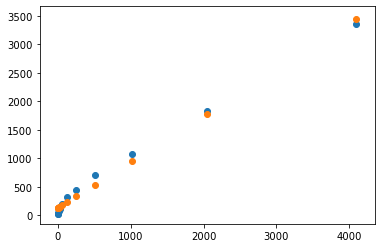

In [19]:
os.system("g++ -ffast-math -march=native -O3 measure_linvbin.cpp")
os.system("./a.out > bvl.csv")

df = pd.read_csv("bvl.csv", header=None, names=["method", "err", "time"])
df["time"] /= 50000


from scipy.stats import linregress
x = df[df.method == "linear"]["err"]
y = df[df.method == "linear"]["time"]

lslope, lintercept, lrval, _, _ = linregress(x, y)
def lin_mod(x):
    return lslope * x + lintercept

assert lrval > 0.98

plt.scatter(x, y)
plt.scatter(x, lin_mod(x))

0.9813228756603523


381.2242997209705

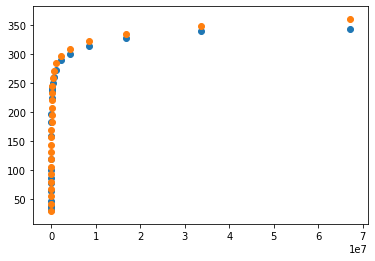

In [20]:
import numpy as np
x = df[df.method == "binary"]["err"]
y = df[df.method == "binary"]["time"]
slope, intercept, rval, _, _ = linregress(np.log(x), y)
print(rval)
def bin_mod(x):
    return np.log(x) * slope + intercept

plt.scatter(x, y)
plt.scatter(x, bin_mod(x))
bin_mod(200_000_000)

In [21]:
DATA_PATH = "../SOSD/data/osm_cellids_200M_uint64"

In [22]:
top_only_layers = ["radix", "bradix"]
anywhere_layers = ["linear", "cubic"]
specialty_top_layers = ["histogram", "loglinear", "normal", "lognormal"]
branching_factors = [2**x for x in range(7, 22)]

In [23]:
all_top_layers = top_only_layers + anywhere_layers

In [24]:
# first, build a grid of the most likely configs
configs = []
nmspc_counter = 0
for top in all_top_layers:
    for bot in anywhere_layers:
        for bf in branching_factors[::3]:
            configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1
            
# next, build a few tests to see if a speciality layer would help
for top in specialty_top_layers:
    if top == "histogram":
        for bot in anywhere_layers:
            for bf in [64, 128, 256]:
                configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
                nmspc_counter += 1
    else:
        # not a histogram
        for bot in anywhere_layers:
            for bf in branching_factors[::4]:
                configs.append({"layers": f"{top},{bot}", "branching factor": bf, "namespace": f"nm{nmspc_counter}"})
                nmspc_counter += 1


In [25]:
def parallel_test_rmis(configs, threads=2, phase=""):
    jobs = [[] for _ in range(threads)]
    procs = []
    
    for idx, conf in enumerate(configs):
        jobs[idx % threads].append(conf)
        
    for idx, workset in enumerate(jobs):
        fn = f"{phase}{idx}.json"
        with open(fn, "w") as f:
            json.dump({"configs": workset}, f)
        cmd = f"RUST_BACKTRACE=1 RUST_LOG=trace cargo run --release {DATA_PATH} --param-grid {fn}"
        procs.append(subprocess.Popen(cmd, shell=True))

    print("Spawned", threads, "processes with", [len(x) for x in jobs], "jobs each")
    
    for proc in procs:
        proc.wait()
        
    
    os.system("mv nm* opt/")
    data = []
    for idx, _ in enumerate(jobs):
        fn = f"{phase}{idx}.json_results"
        with open(fn, "r") as f:
            data.extend(json.load(f))

    return data
    

In [26]:
print("Testing", len(configs), "initial configurations.")

step1_results = parallel_test_rmis(configs, phase="step1")
step1_results = pd.DataFrame(step1_results)

Testing 70 initial configurations.
Spawned 2 processes with [35, 35] jobs each


In [27]:
display(HTML(step1_results.to_html()))

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace
0,"radix,linear",128,1.677722e+07,24.181279,48362559,24.181279,17536,16512,nm0
1,"radix,linear",8192,2.677103e+05,2.301554,4603109,2.301554,1114240,1048704,nm2
2,"radix,linear",524288,1.767429e+04,0.371465,742930,0.371465,71303296,67108992,nm4
3,"radix,cubic",1024,1.048576e+06,3.643267,7286535,3.643267,270464,262272,nm6
4,"radix,cubic",65536,6.498579e+04,0.340148,680296,0.340148,17301632,16777344,nm8
5,"bradix,linear",128,6.668574e+06,10.719710,21439421,10.719710,17600,16576,nm10
6,"bradix,linear",8192,2.425310e+05,0.640173,1280346,0.640173,1114304,1048768,nm12
7,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,71303360,67109056,nm14
8,"bradix,cubic",1024,1.048576e+06,3.054265,6108530,3.054265,270528,262336,nm16
9,"bradix,cubic",65536,4.339321e+04,0.326746,653493,0.326746,17301696,16777408,nm18


In [28]:
import pystache
with open("bench.cpp", "r") as f:
    template = f.read()
    
with open("step1.cpp", "w") as f:
    f.write(pystache.render(template, 
                            {"filename": DATA_PATH, 
                             "namespaces": step1_results.namespace.tolist()}))
    
os.system("g++ -Wall -O3 -ffast-math -march=native step1.cpp " + " ".join("opt/" + x + ".cpp" for x in step1_results.namespace.tolist()))

os.system("./a.out > inference.txt")
with open("inference.txt") as f:
    inference = list(int(x.strip()[:-2]) / 100000.0 for x in f)
    
step1_results["inference"] = inference

In [29]:
step1_results["pred_time_lin"] = step1_results.inference + lin_mod(step1_results["average error"])
step1_results["pred_time_bin"] = step1_results.inference + bin_mod(step1_results["average error"])
step1_results["pred_time"] = step1_results[["pred_time_lin", "pred_time_bin"]].min(axis=1)
step1_results

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,inference,pred_time_lin,pred_time_bin,pred_time
0,"radix,linear",128,1.677722e+07,24.181279,48362559,24.181279,17536,16512,nm0,8.08337,1.359215e+07,343.586727,343.586727
1,"radix,linear",8192,2.677103e+05,2.301554,4603109,2.301554,1114240,1048704,nm2,6.84560,2.170172e+05,266.011252,266.011252
2,"radix,linear",524288,1.767429e+04,0.371465,742930,0.371465,71303296,67108992,nm4,12.34584,1.445677e+04,221.372148,221.372148
3,"radix,cubic",1024,1.048576e+06,3.643267,7286535,3.643267,270464,262272,nm6,8.30775,8.496348e+05,292.660884,292.660884
4,"radix,cubic",65536,6.498579e+04,0.340148,680296,0.340148,17301632,16777344,nm8,10.43542,5.278414e+04,243.482793,243.482793
...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,"normal,cubic",524288,9.373862e+03,0.080985,161970,0.080985,138412224,134217920,nm61,57.26807,7.777124e+03,254.594572,254.594572
66,"lognormal,linear",2048,2.677468e+05,2.740989,5481979,2.740989,278720,262336,nm63,37.07986,2.170770e+05,296.248025,296.248025
67,"lognormal,linear",524288,1.031079e+04,0.113245,226490,0.113245,71303360,67109056,nm65,58.19512,8.537097e+03,257.279127,257.279127
68,"lognormal,cubic",2048,4.199088e+05,1.904676,3809352,1.904676,540864,524480,nm67,39.22184,3.403527e+05,306.691773,306.691773


In [30]:
def pareto_mask(df):
    # find Pareto efficient RMIs
    mask = []
    for idx1, el1 in df.iterrows():
        my_size = el1["size linear search"]
        my_time = el1["pred_time"]
        for idx2, el2 in df.iterrows():
            if idx1 == idx2:
                continue

            if ((el2["size linear search"] <= my_size) 
                and (el2["pred_time"] <= my_time)):
                mask.append(False)
                break
        else:
            mask.append(True)
    return mask

In [31]:
mask = pareto_mask(step1_results)
pareto = step1_results[mask]
print("Found", len(pareto), "Pareto efficient models")
display(HTML(pareto.to_html()))

Found 9 Pareto efficient models


,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,inference,pred_time_lin,pred_time_bin,pred_time
2,"radix,linear",524288,1.767429e+04,0.371465,742930,0.371465,71303296,67108992,nm4,12.34584,1.445677e+04,221.372148,221.372148
7,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,71303360,67109056,nm14,16.79268,6.779167e+03,211.632924,211.632924
10,"linear,linear",128,2.339913e+06,5.746346,11492692,5.746346,17536,16512,nm20,13.58721,1.895813e+06,312.748635,312.748635
11,"linear,linear",8192,1.310720e+05,0.825524,1651049,0.825524,1114240,1048704,nm22,14.79115,1.063280e+05,260.781617,260.781617
15,"cubic,linear",128,2.097152e+06,6.403989,12807979,6.403989,17664,16640,nm30,12.26965,1.699140e+06,309.410340,309.410340
24,"loglinear,linear",32768,9.235826e+04,0.886314,1772628,0.886314,4456576,4194432,nm48,8.33867,7.495777e+04,247.870825,247.870825
36,"radix,linear",65536,5.530521e+04,0.493501,987001,0.493501,8913024,8388736,nm3,6.54206,4.493755e+04,236.613655,236.613655
41,"bradix,linear",65536,4.993954e+04,0.989075,1978150,0.989075,8913088,8388800,nm13,7.58583,4.059161e+04,235.774674,235.774674
45,"linear,linear",1024,5.411146e+05,3.355415,6710829,3.355415,139392,131200,nm21,12.94587,4.385210e+05,285.094235,285.094235


In [34]:
candidate_layers = set(pareto["layers"])
next_configs = []
nmspc_counter = 0
for candidate in candidate_layers:
    if candidate.startswith("histogram"):
        for bf in [32, 300, 512]:
            next_configs.append({"layers": candidate, "branching factor": bf,
                                 "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1

    else:
        already_known = step1_results[step1_results.layers == candidate]["branching factor"].to_list()
        for bf in sorted(set(branching_factors) - set(already_known)):
            next_configs.append({"layers": candidate, "branching factor": bf,
                                 "namespace": f"nm{nmspc_counter}"})
            nmspc_counter += 1

In [35]:
print("Testing", len(next_configs), "additional configurations.")
step2_results = parallel_test_rmis(next_configs, phase="step2")
step2_results = pd.DataFrame(step2_results)

Testing 51 additional configurations.
Spawned 2 processes with [26, 25] jobs each


In [39]:
import pystache
with open("bench.cpp", "r") as f:
    template = f.read()
    
with open("step2.cpp", "w") as f:
    f.write(pystache.render(template, 
                            {"filename": DATA_PATH, 
                             "namespaces": step2_results.namespace.tolist()}))
    

In [40]:
print("Compiling...")
os.system("g++ -Wall -O3 -ffast-math -march=native step2.cpp " + " ".join("opt/" + x + ".cpp" for x in step2_results.namespace.tolist()))

print("Executing...")
os.system("./a.out > inference.txt")
with open("inference.txt") as f:
    inference = list(int(x.strip()[:-2]) / 100000.0 for x in f)
    
step2_results["inference"] = inference

Compiling...
Executing...


In [41]:
step2_results["pred_time_lin"] = step2_results.inference + lin_mod(step2_results["average error"])
step2_results["pred_time_bin"] = step2_results.inference + bin_mod(step2_results["average error"])
step2_results["pred_time"] = step2_results[["pred_time_lin", "pred_time_bin"]].min(axis=1)
step2_results

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,inference,pred_time_lin,pred_time_bin,pred_time
0,"bradix,linear",256,2.915224e+06,4.406203,8812405,4.406203,35008,32960,nm0,7.28648,2.361893e+06,310.503497,310.503497
1,"bradix,linear",2048,5.242880e+05,1.683031,3366062,1.683031,278720,262336,nm2,7.36231,4.248834e+05,278.927888,278.927888
2,"bradix,linear",16384,1.131330e+05,1.234042,2468084,1.234042,2228416,2097344,nm4,7.86797,9.178786e+04,251.143125,251.143125
3,"bradix,linear",131072,2.785320e+04,0.235951,471902,0.235951,17825984,16777408,nm6,11.67653,2.270251e+04,229.093910,229.093910
4,"bradix,linear",1048576,6.698896e+03,0.237345,474690,0.237345,142606528,134217920,nm8,23.91402,5.576654e+03,215.042136,215.042136
5,"linear,linear",256,2.571956e+06,3.666593,7333185,3.666593,34944,32896,nm10,17.55826,2.083806e+06,318.464051,318.464051
6,"linear,linear",2048,2.677109e+05,2.516818,5033637,2.516818,278656,262272,nm12,14.13466,2.170250e+05,273.300357,273.300357
7,"linear,linear",16384,1.127650e+05,0.655880,1311761,0.655880,2228352,2097280,nm14,15.92758,9.149781e+04,259.142631,259.142631
8,"linear,linear",131072,4.688234e+04,0.655732,1311463,0.655732,17825920,16777344,nm16,25.67096,3.813291e+04,252.694373,252.694373
9,"linear,linear",1048576,3.330170e+04,0.655730,1311459,0.655730,142606464,134217856,nm18,53.18573,2.715811e+04,273.899140,273.899140


In [42]:
all_results = pd.concat((step1_results, step2_results)).reset_index(drop=True)
mask = pareto_mask(all_results)
all_results.sort_values("pred_time")

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,inference,pred_time_lin,pred_time_bin,pred_time
100,"bradix,linear",2097152,3.642854e+03,0.110757,221515,0.110757,285212864,268435648,nm9,25.72665,3.102623e+03,205.616366,205.616366
84,"radix,linear",1048576,8.192000e+03,0.104105,208211,0.104105,142606464,134217856,nm28,16.15819,6.778532e+03,210.998434,210.998434
110,"radix,linear",2097152,6.698896e+03,0.237345,474690,0.237345,285212800,268435584,nm29,20.00305,5.572744e+03,211.131166,211.131166
7,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,71303360,67109056,nm14,16.79268,6.779167e+03,211.632924,211.632924
74,"bradix,linear",1048576,6.698896e+03,0.237345,474690,0.237345,142606528,134217920,nm8,23.91402,5.576654e+03,215.042136,215.042136
...,...,...,...,...,...,...,...,...,...,...,...,...,...
29,"normal,cubic",128,3.181976e+06,3.557154,7114308,3.557154,33984,32960,nm58,24.51030,2.578019e+06,329.342596,329.342596
37,"radix,cubic",128,8.388608e+06,14.061114,28122228,14.061114,33920,32896,nm5,7.96620,6.796140e+06,330.682001,330.682001
31,"lognormal,linear",128,2.097152e+06,6.347064,12694128,6.347064,17600,16576,nm62,36.93018,1.699164e+06,334.070870,334.070870
33,"lognormal,cubic",128,2.692245e+06,5.836464,11672928,5.836464,33984,32960,nm66,39.74614,2.181280e+06,341.495187,341.495187


In [43]:
display(HTML(all_results.sort_values("pred_time").to_html()))

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,inference,pred_time_lin,pred_time_bin,pred_time
100,"bradix,linear",2097152,3.642854e+03,0.110757,221515,0.110757,285212864,268435648,nm9,25.72665,3.102623e+03,205.616366,205.616366
84,"radix,linear",1048576,8.192000e+03,0.104105,208211,0.104105,142606464,134217856,nm28,16.15819,6.778532e+03,210.998434,210.998434
110,"radix,linear",2097152,6.698896e+03,0.237345,474690,0.237345,285212800,268435584,nm29,20.00305,5.572744e+03,211.131166,211.131166
7,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,71303360,67109056,nm14,16.79268,6.779167e+03,211.632924,211.632924
74,"bradix,linear",1048576,6.698896e+03,0.237345,474690,0.237345,142606528,134217920,nm8,23.91402,5.576654e+03,215.042136,215.042136
44,"bradix,cubic",524288,8.606034e+03,0.041092,82184,0.041092,138412224,134217920,nm19,20.79022,7.118593e+03,216.540080,216.540080
2,"radix,linear",524288,1.767429e+04,0.371465,742930,0.371465,71303296,67108992,nm4,12.34584,1.445677e+04,221.372148,221.372148
99,"bradix,linear",262144,1.767429e+04,0.371465,742930,0.371465,35651776,33554624,nm7,12.63882,1.445706e+04,221.665128,221.665128
39,"radix,cubic",524288,1.730993e+04,0.121467,242934,0.121467,138412160,134217856,nm9,16.60270,1.416584e+04,225.244708,225.244708
109,"radix,linear",262144,2.785320e+04,0.235951,471902,0.235951,35651712,33554560,nm27,9.68177,2.270052e+04,227.099150,227.099150


In [46]:
def human_size(bytes, units=[' bytes','KB','MB','GB','TB', 'PB', 'EB']):
    """ Returns a human readable string reprentation of bytes"""
    return str(bytes) + units[0] if bytes < 1024 else human_size(bytes>>10, units[1:])

all_hresults = all_results.copy()
all_hresults["size linear search"] = [human_size(x) for x in all_results["size linear search"].to_list()]
all_hresults["size binary search"] = [human_size(x) for x in all_results["size binary search"].to_list()]
all_hresults[mask].sort_values("pred_time")

,layers,branching factor,average error,average error %,max error,max error %,size binary search,size linear search,namespace,inference,pred_time_lin,pred_time_bin,pred_time
100,"bradix,linear",2097152,3.642854e+03,0.110757,221515,0.110757,272MB,256MB,nm9,25.72665,3.102623e+03,205.616366,205.616366
84,"radix,linear",1048576,8.192000e+03,0.104105,208211,0.104105,136MB,128MB,nm28,16.15819,6.778532e+03,210.998434,210.998434
7,"bradix,linear",524288,8.192000e+03,0.104105,208211,0.104105,68MB,64MB,nm14,16.79268,6.779167e+03,211.632924,211.632924
2,"radix,linear",524288,1.767429e+04,0.371465,742930,0.371465,68MB,64MB,nm4,12.34584,1.445677e+04,221.372148,221.372148
99,"bradix,linear",262144,1.767429e+04,0.371465,742930,0.371465,34MB,32MB,nm7,12.63882,1.445706e+04,221.665128,221.665128
109,"radix,linear",262144,2.785320e+04,0.235951,471902,0.235951,34MB,32MB,nm27,9.68177,2.270052e+04,227.099150,227.099150
73,"bradix,linear",131072,2.785320e+04,0.235951,471902,0.235951,17MB,16MB,nm6,11.67653,2.270251e+04,229.093910,229.093910
41,"bradix,linear",65536,4.993954e+04,0.989075,1978150,0.989075,8MB,8MB,nm13,7.58583,4.059161e+04,235.774674,235.774674
36,"radix,linear",65536,5.530521e+04,0.493501,987001,0.493501,8MB,8MB,nm3,6.54206,4.493755e+04,236.613655,236.613655
98,"bradix,linear",32768,5.530521e+04,0.493501,987001,0.493501,4MB,4MB,nm5,6.87665,4.493788e+04,236.948245,236.948245


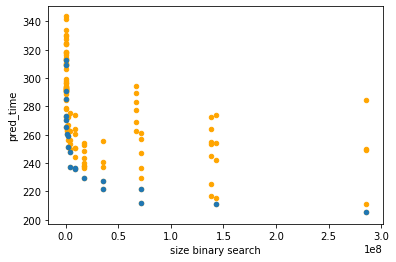

In [57]:
ax = all_results.plot.scatter("size binary search", "pred_time", color="orange")
all_results[mask].plot.scatter("size binary search", "pred_time", ax=ax)